In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
basefolder = 'C:/Users/karim/Documents/westgate/data/training/default/'

In [3]:
import pandas as pd
from westgate.flaml_model import *
import pandas as pd
from westgate.combochart import combo_chart
import argparse
from colored import Fore, Back, Style
from sklearn.ensemble._stacking import StackingClassifier
import sqlite3

In [48]:
default_model = UWModel(experiment_id='default_1.0')
#default_model = load_model('default_1.0')

In [49]:
data_2022_df = pd.read_csv(basefolder + 'loan_outcomes_2022.csv', encoding='latin')

C:\Users\karim\AppData\Local\Temp\ipykernel_32548\2959394401.py:1: DtypeWarning: Columns (741) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2022_df = pd.read_csv(basefolder + 'loan_outcomes_2022.csv', encoding='latin')


In [58]:
jan2023_df = pd.read_csv(basefolder + 'loan_outcomes_jan2023.csv', encoding='latin')
feb2023_df = pd.read_csv(basefolder + 'loan_outcomes_feb2023.csv', encoding='latin')
mar2023_df = pd.read_csv(basefolder + 'loan_outcomes_mar2023.csv', encoding='latin')

In [59]:
accepted_df = pd.concat([data_2022_df, jan2023_df, feb2023_df, mar2023_df])

In [60]:
len(accepted_df)

12883

In [61]:
accepted_df['request_yyyymm'] = accepted_df['request_date'].str[0:7]
accepted_df['validation_flag'] = accepted_df['request_yyyymm'].isin(['2023-01', '2023-02'])
accepted_df['test_flag'] = accepted_df['request_yyyymm'].isin(['2023-03'])
accepted_df['weight'] = np.select(
    [
        accepted_df['request_yyyymm'] == '2022-01',
        accepted_df['request_yyyymm'] == '2022-02',
        accepted_df['request_yyyymm'] == '2022-03',
        accepted_df['request_yyyymm'] == '2022-04',
        accepted_df['request_yyyymm'] == '2022-05',
        accepted_df['request_yyyymm'] == '2022-06',
        accepted_df['request_yyyymm'] == '2022-07',
        accepted_df['request_yyyymm'] == '2022-08',
        accepted_df['request_yyyymm'] == '2022-09',
        accepted_df['request_yyyymm'] == '2022-10',
        accepted_df['request_yyyymm'] == '2022-11',
        accepted_df['request_yyyymm'] == '2022-12',
        accepted_df['request_yyyymm'] == '2023-01',
        accepted_df['request_yyyymm'] == '2023-02',
        accepted_df['request_yyyymm'] == '2023-03'
    ],
    [
        1/12,
        2/12,
        3/12,
        4/12,
        5/12,
        6/12,
        7/12,
        8/12,
        9/12,
        10/12,
        11/12,
        1,
        1,
        1,
        1
    ],
    default=1
)


In [62]:
accepted_df['profit'] = accepted_df['total_paid'] - accepted_df['principal']

In [63]:
accepted_df[default_model.target] = np.where(accepted_df['profit'] < 50, 1, 0)

In [64]:
accepted_df[default_model.target].value_counts(normalize=True)

status
0    0.708763
1    0.291237
Name: proportion, dtype: float64

In [65]:
filtered_df = default_model.filter_df(accepted_df)

2 Rows with 'account_age_days' column not positive have been discarded.


In [15]:
len(filtered_df)

9507

In [66]:
filtered_df[default_model.target].value_counts(normalize=True)

status
0    0.710268
1    0.289732
Name: proportion, dtype: float64

In [17]:
#not used
#rs = ShuffleSplit(n_splits=1, test_size=.20, random_state=0)

In [68]:
# here X_teste is December

X_train, X_test, y_train, y_test, extra = default_model.split_data(filtered_df, 
                                                            split_criteria='test_flag',
                                                            extra_cols=['weight', 'validation_flag', 'request_yyyymm'])

X_train, X_test = default_model.feature_engineer(X_train, X_test)

#TODO: deal with na values in X_train/X_test if any
#non_na_idx = X['age'].notna()

#X = X[non_na_idx]

#if y is not None:
    #y = y[non_na_idx]



In [69]:
extra.keys()

dict_keys(['train_weight', 'test_weight', 'train_validation_flag', 'test_validation_flag', 'train_request_yyyymm', 'test_request_yyyymm', 'train_profit', 'test_profit', 'train_request_date', 'test_request_date', 'train_dob', 'test_dob'])

In [70]:
len(X_train)

11392

In [71]:
X_val, y_val = X_train.loc[extra['train_validation_flag']], y_train.loc[extra['train_validation_flag']]
X_train, y_train = X_train.loc[~extra['train_validation_flag']], y_train.loc[~extra['train_validation_flag']]

In [72]:
len(X_train) + len(X_val) + len(X_test) == len(filtered_df)

True

In [73]:
weight_train = extra['train_weight'].loc[~extra['train_validation_flag']]
weight_val = extra['train_weight'].loc[extra['train_validation_flag']]
weight_test = extra['test_weight']

In [74]:
len(weight_train), len(weight_val), len(weight_test)

(9507, 1885, 840)

In [75]:
len(X_train), len(X_val), len(X_test)

(9507, 1885, 840)

X_train shape: (9507, 26)
X_test shape: (840, 26)



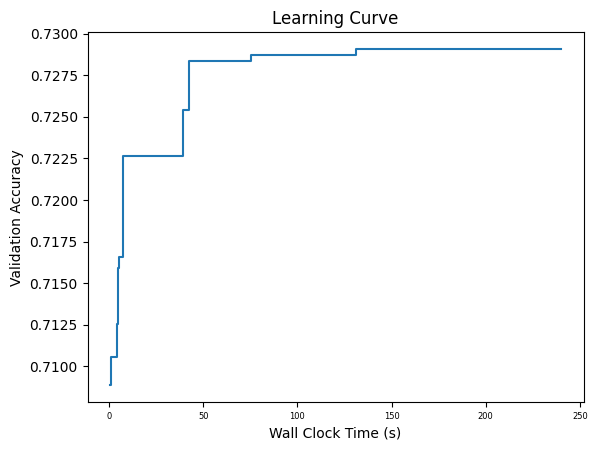

Actual Default[TEST]:
245 (29.2%)
Predicted Default[TEST]:
84 (10.0%)

y_pred_proba distribution:
(0.0455, 0.117]    131
(0.117, 0.188]     223
(0.188, 0.259]     149
(0.259, 0.33]      101
(0.33, 0.4]         73
(0.4, 0.471]        63
(0.471, 0.542]      41
(0.542, 0.613]      30
(0.613, 0.684]      20
(0.684, 0.755]       9
Name: count, dtype: int64

Best validation loss: 0.27092137187181686


              precision    recall  f1-score   support

           0       0.75      0.95      0.84       595
           1       0.67      0.23      0.34       245

    accuracy                           0.74       840
   macro avg       0.71      0.59      0.59       840
weighted avg       0.73      0.74      0.69       840

Normalized confusion matrix:
[[0.95294118 0.04705882]
 [0.77142857 0.22857143]]


Saving X_test-default_1.0.csv
Profitability stats
----
Predicted profit [TEST]: $160946.00
Actual profit [TEST]: $157235.00
Anti-profit [TEST]: $-3711.00
Anti-profit per loan [TEST]: $-4.00
--

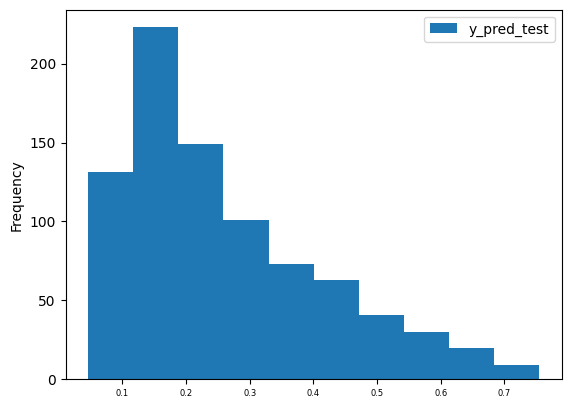

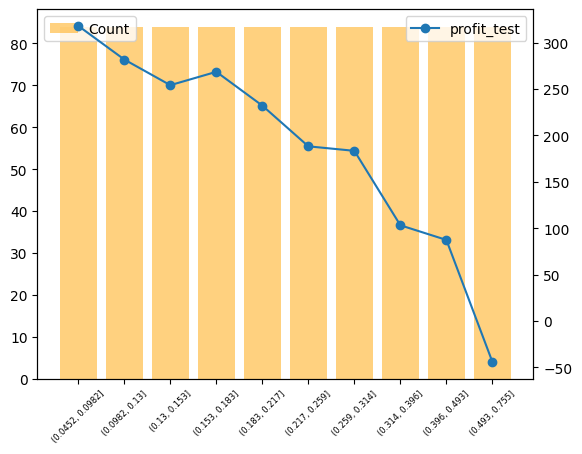

In [79]:
def p90_accuracy_metric(X_val, y_val, estimator, labels,
                X_train, y_train, weight_val=None, weight_train=None,
                *args):
    y_probas = estimator.predict_proba(X_val)[:, 1]
    df = pd.DataFrame({'proba': y_probas, 'y_val': y_val})
    perc90 = np.percentile(y_probas, 90)
    perc10 = np.percentile(y_probas, 10)
    delta = df.loc[df['proba'] >= perc90]['y_val'].sum() - df.loc[df['proba'] <= perc10]['y_val'].sum()
    return -delta, {}
        
config = {
    #"ensemble": True,
    "estimator_list": ['xgb_limitdepth'],
    #"estimator_list": ['xgboost'],
    "metric": "roc_auc",
    #"metric": p90_accuracy_metric,
    "eval_method": 'holdout',
    'X_val': X_val,
    'y_val': y_val,
    'sample_weight': weight_train,
    'sample_weight_val': weight_val
}

y_pred_proba, y_pred, extra = default_model.fit(
        X_train, X_test, y_train, y_test, extra,
        time_budget=240, 
        automl_config=config,
        show_plots=True,
        percentile=90
)

In [89]:
len(default_model.features)

34

In [90]:
print(default_model.features)

['account_age_days', 'average_closing_balance_day_after_employer_income', 'average_closing_balance_day_of_employer_income', 'average_closing_balance_day_of_income', 'average_employer_a_income_deposit', 'average_monthly_employer_income_complex', 'average_monthly_micro_loan_payments_complex', 'average_monthly_total_recurring_deposits_complex', 'average_monthly_total_recurring_payments_complex', 'average_monthly_utility_payments_complex', 'balance_90_days_ago', 'balance_current', 'balance_min', 'count_active_days', 'count_days_negative_balance_90_days', 'count_distinct_micro_lenders', 'count_loan_payments_3_months_ago', 'count_loan_payments_current_month', 'count_loan_payments_previous_month', 'count_nsf_30_days', 'employer_income_frequency', 'sum_employer_income_2_months_ago', 'sum_employer_income_current_month', 'sum_employer_income_previous_month', 'sum_loan_payments', 'sum_non_employer_income', 'sum_non_employer_income_2_months_ago', 'sum_non_employer_income_current_month', 'sum_non_e

In [80]:
Xfull = pd.concat([X_train, X_val, X_test])

In [81]:
yfull = pd.concat([y_train, y_val, y_test])

In [82]:
weight_full = pd.concat([weight_train, weight_val, weight_test])

In [84]:
default_model.automl.retrain_from_log(
    'log_default_1.0.log',
    Xfull,
    yfull,
    train_best=True,
    train_full=True,
    sample_weight=weight_full,
    time_budget=60
)

[flaml.automl.logger: 04-18 10:27:47] {804} INFO - log file name log_default_1.0.log
[flaml.automl.logger: 04-18 10:27:47] {857} INFO - estimator = xgb_limitdepth, config = {'n_estimators': 23, 'max_depth': 7, 'min_child_weight': 2.4698148528364117, 'learning_rate': 0.06915461373602601, 'subsample': 1.0, 'colsample_bylevel': 0.6743531313867481, 'colsample_bytree': 0.7900825535523176, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0135771434780656}, #training instances = 12232
[flaml.automl.logger: 04-18 10:27:48] {890} INFO - retrain from log succeeded


59.575676918029785

In [86]:
preds_full = default_model.predict_proba(Xfull, filter=False, engineer=False)

In [87]:
percentiles = np.percentile(preds_full['pred_proba'], range(5,100,5))
percentiles

array([0.12762495, 0.14132896, 0.15461702, 0.16716389, 0.17870175,
       0.19176946, 0.20420896, 0.21847297, 0.23281443, 0.24923465,
       0.26662582, 0.28684813, 0.30964496, 0.33677232, 0.36805492,
       0.40551628, 0.44971884, 0.50154353, 0.56646273])

In [88]:
default_model.percentiles = {p:v for p,v in zip(range(5,100,5), percentiles)}
default_model.percentiles 

{5: 0.12762495130300522,
 10: 0.1413289561867714,
 15: 0.15461701527237892,
 20: 0.16716389060020448,
 25: 0.1787017472088337,
 30: 0.1917694628238678,
 35: 0.20420896112918852,
 40: 0.2184729725122452,
 45: 0.23281442523002624,
 50: 0.2492346465587616,
 55: 0.2666258245706558,
 60: 0.28684812784194946,
 65: 0.30964495539665227,
 70: 0.3367723226547241,
 75: 0.36805491894483566,
 80: 0.4055162847042084,
 85: 0.4497188448905945,
 90: 0.5015435338020324,
 95: 0.5664627254009247}

Saving / loading the model

In [89]:
default_model.save()

In [21]:
default_model = load_model('default_1.0')

In [4]:
default_model.feat_imp()

,variable,imp
13,count_loan_payments_previous_month,0.122576
5,average_monthly_micro_loan_payments_complex,0.106857
11,count_distinct_micro_lenders,0.093204
12,count_loan_payments_current_month,0.042197
23,other_loan_payments_average,0.041419
6,average_monthly_utility_payments_complex,0.036522
8,balance_current,0.032088
15,sum_employer_income_2_months_ago,0.031807
17,sum_employer_income_previous_month,0.031602
22,telecom_payments_average,0.031142


In [27]:
default_model.save()

# Predictions for Jan'23

In [42]:
data2023_df = pd.read_csv('../data/janToNov2023Loansv2.csv', encoding='latin')

C:\Users\karim\AppData\Local\Temp\ipykernel_3504\4126847242.py:1: DtypeWarning: Columns (387) have mixed types. Specify dtype option on import or set low_memory=False.
  data2023_df = pd.read_csv('../data/janToNov2023Loansv2.csv', encoding='latin')


In [43]:
len(data2023_df)

9499

In [44]:
jan23_df = data2023_df.loc[data2023_df['request_date'].str[:7]=='2023-01']

In [45]:
len(jan23_df)

1045

In [46]:
jan23_df.drop_duplicates(inplace=True)

In [47]:
len(jan23_df)

1040

In [58]:
jan23_df.set_index('loanId', inplace=True)

In [59]:
jan23_df.head()

,dob,gender,request_date,account_age_days,active_days_trend,auto_loan_payment_frequency,average_closing_balance_day_after_employer_income,average_closing_balance_day_after_government_income,average_closing_balance_day_after_income,average_closing_balance_day_of_employer_income,...,sum_wsib_income,student_loan_payments_frequency,telecom_payments_frequency,telecom_payments_average,other_loan_payments_frequency,other_loan_payments_average,utility_payments_frequency,utility_payments_average,average_monthly_insurance_income_complex,MostRecentTransactionDate
loanId,,,,,,,,,,,,,,,,,,,,,
3970620,1991-09-15,Female,2023-01-19,366.0,1.03,Monthly,364.90,85.89,297.83,329.04,...,0.0,Unknown,Unknown,143.38,BiWeekly,293.26,NONE_DETECTED,0.00,7.27,05/25/2023
3986502,1991-11-07,Female,2023-01-31,365.0,1.02,NONE_DETECTED,381.74,269.92,276.69,411.25,...,0.0,NONE_DETECTED,Unknown,130.27,NONE_DETECTED,0.00,NONE_DETECTED,0.00,0.00,06/19/2023
3813879,1989-08-16,Male,2023-01-02,366.0,1.06,Weekly,996.93,-55.76,835.17,1153.10,...,0.0,NONE_DETECTED,NONE_DETECTED,0.00,Weekly,83.37,NONE_DETECTED,0.00,0.00,08/29/2023
3814985,2004-02-04,Male,2023-01-03,365.0,0.74,NONE_DETECTED,1178.11,1.26,1114.36,1249.69,...,0.0,NONE_DETECTED,Monthly,40.40,NONE_DETECTED,0.00,Unknown,76.93,0.40,04/21/2023
3813995,1992-08-21,Male,2023-01-02,366.0,1.08,NONE_DETECTED,522.96,170.62,429.96,525.33,...,0.0,NONE_DETECTED,Unknown,163.80,BiWeekly,279.30,Unknown,157.44,1.08,08/07/2023


In [48]:
loans23_df = pd.read_csv('../data/loans_branch-if-jan2023.csv')

In [49]:
loans23_df['profit'] = loans23_df['Paid Amount'] - loans23_df['Principal Amount']

In [50]:
loans23_df.set_index('Loan Id', inplace=True)

In [55]:
len(loans23_df)

31510

In [56]:
loans23_df.sort_index().head()

,Loan #,Loan Duration,Maturity Date,First Name,Last Name,Full Name,Released Date,Principal Amount,Disbursed By,Paid Amount,...,Total Interest Paid,Total Penalty Balance,Total Penalty Paid,Pending Due,Pending Fees Due,Pending Interest Due,Pending Penalty Due,Pending Principal Due,Balance Amount,profit
Loan Id,,,,,,,,,,,,,,,,,,,,,
2545807,IF10000083,3 Months,02/24/2022,Brian,Robert Wason,Brian Robert Wason,12/02/2021,300.0,Cash,587.58,...,17.58,0.0,0.0,0.00,NaN,NaN,NaN,NaN,0.00,287.58
2545954,IF10000085,3 Months,02/18/2022,Ashley,Sarah Pulker,Ashley Sarah Pulker,12/02/2021,300.0,Online Transfer,391.72,...,11.72,110.0,0.0,305.86,90.0,5.86,110.0,100.0,305.86,91.72
2545977,IF10000086,2 Months,01/31/2022,Anpalagan,Dilajini,Anpalagan Dilajini,12/02/2021,200.0,Cash,379.74,...,7.74,0.0,0.0,0.00,90.0,5.86,110.0,100.0,0.00,179.74
2545990,IF10000087,3 Months,02/24/2022,Kenneth,Payne,Kenneth Payne,12/02/2021,350.0,Cash,880.51,...,20.51,0.0,210.0,0.00,90.0,5.86,110.0,100.0,0.00,530.51
2546124,IF10000091,3 Months,02/24/2022,Dawn Eleanor,Bailey,Dawn Eleanor Bailey,12/02/2021,300.0,Cash,587.58,...,17.58,0.0,0.0,0.00,90.0,5.86,110.0,100.0,0.00,287.58


In [60]:
jan23_ex_df = pd.merge(jan23_df, loans23_df, left_index=True, right_index=True, validate='one_to_one')

In [61]:
len(jan23_ex_df)

1040

In [62]:
jan23_ex_df['pred_proba'] = default_model.predict_proba(jan23_ex_df)['pred_proba']

In [63]:
predicted_defaults_df = jan23_ex_df.loc[jan23_ex_df['pred_proba'] >= p90_2022]

In [64]:
len(predicted_defaults_df), len(jan23_ex_df), len(predicted_defaults_df) / len(jan23_ex_df) 

(74, 1040, 0.07115384615384615)

In [65]:
profit_jan23 = predicted_defaults_df['profit'].sum() / len(predicted_defaults_df)
profit_jan23

-16.31202702702702

# Predictions for all 2022 + jan'23

In [66]:
request_month = pd.concat([extra['train_request_month'], extra['test_request_month']])
profits = pd.concat([extra['train_profit'], extra['test_profit']])

In [67]:
res_list = []

for month in range(1, 13):
    X_month = X2022.loc[request_month == month]
    profits_month = profits.loc[request_month == month]
    preds_df = default_model.predict_proba(X_month, filter=False, engineer=False)
    preds_df['profit'] = profits_month
    predicted_defaults = preds_df.loc[preds_df['pred_proba'] >= p90_2022]
    res_list.append({'month': '2022-' + (str(month) if month >= 10 else '0' + str(month)), 
                    'anti-profit per loan': round(predicted_defaults['profit'].sum() / len(predicted_defaults))})

profits_month = jan23_ex_df['profit']
preds_df = default_model.predict_proba(jan23_ex_df)
preds_df['profit'] = profits_month
predicted_defaults = preds_df.loc[preds_df['pred_proba'] >= p90_2022]
res_list.append({'month': '2023-01', 
                'anti-profit per loan': round(predicted_defaults['profit'].sum() / len(predicted_defaults))})

In [68]:
pd.DataFrame.from_records(res_list)

,month,anti-profit per loan
0,2022-01,-89
1,2022-02,-33
2,2022-03,42
3,2022-04,36
4,2022-05,53
5,2022-06,42
6,2022-07,13
7,2022-08,12
8,2022-09,30
9,2022-10,10


In [236]:
pd.DataFrame.from_records(res_list)['anti-profit per loan'].mean()

33.38461538461539